In [87]:
import pandas as pd
import numpy as np
import csv
import copy
import altair as alt
from collections import Counter
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
import string
from statsmodels.distributions.empirical_distribution import ECDF
import re
from unidecode import unidecode
from collections import defaultdict
import requests # For REST calls
import json # for modelling objects in the JSON format
import os
import csv
import ast
from wikipedia2vec import Wikipedia2Vec
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.datasets import load_iris
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.metrics import silhouette_samples

alt.data_transformers.enable('default', max_rows=None)  #renders if the df has more than 5000 rows

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\giang\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\giang\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


DataTransformerRegistry.enable('default')

In [88]:
path = "E:\Gianluca\Master Big Data Pisa\Progetto_Finale\Agricolo\Facebook\csv_docs_def\comments4_no_spam_nan.csv"
comments_no_nan = pd.read_csv(path, parse_dates=["post_date"], quotechar='"', quoting=csv.QUOTE_ALL, encoding="utf-8", low_memory=False)

In [89]:
def replace_dots(text):
    # This pattern will match sequences of words separated by dots but not acronyms.
    # Acronyms are sequences of single uppercase letters separated by dots and potentially followed by a dot.
    #pattern = r'\b(?:\w+\.\w{2,}|\w{2,}\.\w+)(?:\.\w+)*\b'
    pattern = r'\b(?:[a-zA-Z]+\.[a-zA-Z]{2,}|[a-zA-Z]{2,}\.[a-zA-Z]+)(?:\.[a-zA-Z]+)*\b'
    #pattern = r'\b(?!\d{1,2}\.\d{1,2}\.\d{2,4}\b)(?=\w*[^\d]\w*)(?:\w{2,}\.\w+|\w+\.\w{2,})(?:\.\w+)*\b'

    def replacement(match):
        # Replace dots with spaces in the matched string
        return match.group(0).replace('.', '. ')
    
    # Use re.sub to replace the matched pattern with the replacement function
    return re.sub(pattern, replacement, text)

def replace_commas(text):
    # This pattern will match sequences of words separated by dots but not acronyms.
    # Acronyms are sequences of single uppercase letters separated by dots and potentially followed by a dot.
    #pattern = r'\b(?:\w+\.\w{2,}|\w{2,}\.\w+)(?:\.\w+)*\b'
    pattern = r'\b(?:[a-zA-Z]+,[a-zA-Z]{2,}|[a-zA-Z]{2,},[a-zA-Z]+)(?:,[a-zA-Z]+)*\b'
    #pattern = r'\b(?!\d{1,2}\.\d{1,2}\.\d{2,4}\b)(?=\w*[^\d]\w*)(?:\w{2,}\.\w+|\w+\.\w{2,})(?:\.\w+)*\b'

    def replacement(match):
        # Replace dots with spaces in the matched string
        return match.group(0).replace(',', ', ')
    
    # Use re.sub to replace the matched pattern with the replacement function
    return re.sub(pattern, replacement, text)

def clean_text(text):
    # Rimuove gli articoli con apostrofi come "l'", "all'", ecc.
    cleaned_text = re.sub(r"^(l|all|d|nell|sull|coll|dall|dell|all|quell|quest)'", '', text)
    return cleaned_text

def remove_leading_point(text):
    # Define a pattern to match words starting with a point
    #pattern = r'\W\.\b(?=\w+)'
    pattern = r'(?:(?<=\s)|(?<=^))\.\b(?=\w+)'

    # Use re.sub to remove the leading point from matched words
    result = re.sub(pattern, '', text)

    return result

def remove_ending_point(text):
    # Define a pattern to match words starting with a point
    #pattern = r'\W\.\b(?=\w+)'
    pattern = r'(?:\b)\.$'

    # Use re.sub to remove the leading point from matched words
    result = re.sub(pattern, '', text)

    return result

def remove_hyphen(text):
    # Define a pattern to match words starting with a point
    #pattern = r'\W\.\b(?=\w+)'
    pattern = r'(?<=[a-zA-Z])-(?=[a-zA-Z])'

    # Use re.sub to remove the leading point from matched words
    result = re.sub(pattern, ' ', text)

    return result

def remove_link(text):   
    
    pattern = r'\bhttps?\S+|\bcom/share\S+|\bstory_fbid=\S+|\bcom/story\S+'
    result = re.sub(pattern, '', text)

    return result

def transform_text(text):
    text = str(text).lower()
    text = unidecode(text)
    text = replace_dots(text)
    text = replace_commas(text)
    text = remove_leading_point(text)
    text = remove_hyphen(text)
    text = remove_link(text)
    return text

In [90]:
def remove_receiver(row):
    if row["level"] > 0 and isinstance(row["content"], str):
        receiver_name_len = len(row["type"].split()) - len(row["author"].split()) - 7
        if len(row["content"].split()) >= receiver_name_len:
            token_list = row["content"].split()
            del token_list[:receiver_name_len]
            content_without_receiver = " ".join(token_list)
            row["content"] = content_without_receiver
    return row

# Apply the function to each row
comments_truncated = comments_no_nan.apply(remove_receiver, axis=1)

In [91]:
comments_truncated.head()

,index,comment_id,post_date,post_date_count,comment_date,author,content,likes,level,type,time_of_fetching,author_url,sex
0,0,0,2024-04-20,1,2w,Leo Sileo,Il clima viene controllato con la tecnologia,7,0.0,Comment by Leo Sileo 2 weeks ago,2024-05-06 11:30:55.757595,NaN,0
1,1,1,2024-04-20,1,2w,Luigi Sposato,Yes tutto una manipolazione del clima adesso ...,1,0.0,Comment by Luigi Sposato 2 weeks ago,2024-05-06 11:30:55.757595,NaN,0
2,2,2,2024-04-20,1,2w,Maccioni Bruno,Fresco? C'è il rischio che non rimanga nessun ...,21,0.0,Comment by Maccioni Bruno 2 weeks ago,2024-05-06 11:30:55.773181,NaN,0
3,3,3,2024-04-20,1,2w,Giuseppe Quattromini,colpa del riscaldamento globale,3,1.0,Reply by Giuseppe Quattromini to Maccioni Brun...,2024-05-06 11:30:55.773181,NaN,0
4,4,4,2024-04-20,1,2w,Maccioni Bruno,"Questo io non sono in grado di stabilirlo, pos...",5,2.0,Reply by Maccioni Bruno to Giuseppe Quattromin...,2024-05-06 11:30:55.788802,NaN,0


In [92]:
# This line opens the file from the file system, the file is in the same folder of the notebook and it is opened in "read-only mode"
with open("config.json", 'r') as json_file:
    config = json.load(json_file) # load the json object inside the config file
    KEY = config['d4science_KEY'] # this is the key we will be using for REST calls

In [93]:
TAGME_ENDPOINT = "https://tagme.d4science.org/tagme/tag"
LANG = "it" # Also works in italian and german

In [94]:
def query_tagme(text, long_text=False):
    payload = {"text": text, "gcube-token": KEY, "lang": LANG}
    if long_text:
        # long_text is by defaul false, but if specified by the user, we set the window size at 5
        payload["long_text"] = 5
    r = requests.post(TAGME_ENDPOINT, payload)
    if r.status_code != 200:
        raise Exception("Error on text: {}\n{}".format(text, r.text))
    return r.json()

In [95]:
# Try changing the min_rho parameter and see how it impacts the returned entities
def get_tagme_entities(tagme_response, min_rho=0.3, min_link_probability=0.1):
    ann = tagme_response["annotations"]
    ann = [a for a in ann if a["rho"] > min_rho and a["link_probability"] > min_link_probability] # filter all the annotations with a rho score lower than the threshold
    return ann

def def_value(): 
    return 0

output_file = "E:/Gianluca/Master Big Data Pisa/Progetto_Finale/Agricolo/Facebook/csv_docs_def/comments_entities.csv"
with open(output_file, 'a', encoding='utf-8', newline='') as handle_w:
    csv_writer = csv.writer(handle_w, delimiter=',', quotechar='"', quoting=csv.QUOTE_ALL)
    # se il file è vuoto lungo la prima riga metto l'header
    file_size = os.path.getsize(output_file)  # Find the size of csv file
    if file_size == 0:     # if size is empty 
        headers = ["index", "entities"]
        csv_writer.writerow(headers)
    count = 0
    for index, row in comments_truncated[120000:].iterrows():
        count = count + 1
        print(count)
        text = row["content"]
        try:
            resp = query_tagme(transform_text(text), long_text=True) 
        except:
            continue
        entities = get_tagme_entities(resp, min_rho=0.15, min_link_probability=0)
        csv_writer.writerow([index, entities])
            

In [96]:
def def_value(): 
    return 0

entities_freq = defaultdict(def_value)
entities_flag = {}
entities_link_prob = set()
input_file = "E:/Gianluca/Master Big Data Pisa/Progetto_Finale/Agricolo/Facebook/csv_docs_def/comments_entities.csv"
count = 0
with open(input_file, 'r', encoding='utf-8', newline='') as handle_r:
    reader = csv.DictReader(handle_r)
    for row in reader:
        row_entities = ast.literal_eval(row["entities"])
        if len(row_entities) == 0:
            continue
        else:
            for entity in row_entities:
                try:
                    if entity["title"] not in entities_flag:
                        entities_flag[entity["title"]] = 0
                    if entity["link_probability"] == 1 and entity["rho"] == 0.5:
                        entities_link_prob.add(entity["title"])
                    if entity["link_probability"] != 1 or entity["rho"] != 0.5:
                        entities_flag[entity["title"]] = 1
                except:
                    pass
                try:
                    entities_freq[entity["title"]] = entities_freq[entity["title"]] + 1
                except:
                    count = count + 1
        

In [97]:
# [title for title in entities_flag if entities_flag[title] == 0]
sorted([title for title in entities_flag if entities_flag[title] == 0], key = lambda x: -entities_freq[x])
# print(len([title for title in entities_flag if entities_flag[title] == 0]))

['Rosario Vieni',
 'Non-A',
 'Alex Kinvi-Boh',
 'Hanno tutti ragione',
 'Noi saremo tutto',
 'Dascălu',
 'Paula Seguí',
 'Chi si ferma è perduto',
 'Sei fantastica',
 "Che'Nelle",
 'Pötréte',
 'Scarpe grosse',
 'Nõo',
 'Ancora... grazie a tutti',
 'Emilia Docet',
 'Henri Salvano',
 'Semo La',
 'Greetings from L.A.',
 'Guerra fra poveri',
 'Un bellissimo paese',
 'Viva le donne!',
 'Amedeo Stenti',
 'Alin Bota',
 'La bella gente',
 'William Rarità',
 'I senza Dio (film 1955)',
 'Lavaré',
 'Strání',
 'Lamar Mady',
 'Noi ci saremo',
 'Pietro Bordo di San Superano',
 'Spandiletame',
 'Strelitzia',
 'Guida Michelin',
 'Peter Zelenský',
 'Memento audere semper',
 'Tutti i santi giorni',
 'E io ci sto',
 'La vita è bella (film 1997)',
 'Andrea Cucino',
 'G I R L',
 'SEEE',
 'Questa ragazza è di tutti',
 'Insieme per forza (film 1991)',
 'Malta Amateur Athletic Association',
 'Joseph Ndo',
 'Giacomo Del Gratta',
 'Sono solo parole',
 'AlterVista',
 'Come Dio comanda (film)',
 'Decídete',
 'Fra

In [98]:
len(entities_link_prob)

1206

In [99]:
sorted(list(entities_link_prob), key = lambda x: -entities_freq[x])

['Tutte lo vogliono',
 'Unione europea',
 'Hazdayi Penso',
 'Worstward Ho',
 'Piacé',
 'Tutte e nessuna',
 'Buona Domenica',
 "Storia dell'agricoltura italiana",
 'Carne sintetica',
 'Circo Massimo',
 'Cappello a cono di paglia',
 'Dalla vostra parte',
 'Forza Italia (1994)',
 'Teymur Məmmədov',
 'Provincia di Salerno',
 'Imposta sul reddito delle persone fisiche',
 'La deve smettere!',
 'Provincia di Vicenza',
 'Provincia di Varese',
 'Glifosato',
 'Giorgia Meloni',
 'Bill Gates',
 'Quota latte',
 'Noi con voi',
 'Provincia di Teramo',
 'Assolutamente sì',
 'Provincia di Caserta',
 'Alfabeto fonetico internazionale',
 'Provincia di Sondrio',
 'Ambientalismo',
 'Rosario Vieni',
 'Scuderia Ferrari',
 'Sai xChé?',
 'Allevamento intensivo',
 'Movimento 5 Stelle',
 'Gmail',
 'Non-A',
 'Risorgimento',
 'Loro ed io',
 "Economia d'Italia",
 'Armiamoci e partite!',
 'Intelligenza artificiale',
 'Buona giornata e...',
 'I più grandi di tutti',
 'Se per te',
 'Le vostre richieste',
 'Australia',

In [100]:
len(entities_freq.keys())

12502

In [101]:
sorted(entities_freq.items(), key=lambda x: -x[1])

[('Italia', 7236),
 ('Agricoltura', 6736),
 ('Dio', 3978),
 ('Europa', 3063),
 ('Roma', 2631),
 ('Agricoltore', 2276),
 ('Tutte lo vogliono', 2107),
 ('Politica', 1826),
 ('Unione europea', 1719),
 ('Italiani', 1671),
 ('Sindacato', 1339),
 ('Suolo', 1165),
 ('Comitato Olimpico Internazionale', 1112),
 ('VI secolo', 1099),
 ('Lavoro', 1074),
 ('Facebook', 1074),
 ('Bruxelles', 1026),
 ('Francia', 1011),
 ('Governo', 916),
 ('Euro', 855),
 ('Germania', 841),
 ('Alimento', 823),
 ('Homo sapiens', 776),
 ('Coldiretti', 761),
 ('Letame', 756),
 ('Frutta', 696),
 ('Triticum', 692),
 ('Verdura', 685),
 ('Avanti!', 681),
 ('Roma (città antica)', 670),
 ('Marco Fanno', 664),
 ('Produzione', 634),
 ('Popolo', 616),
 ('Terra', 613),
 ('Roberto Magari', 595),
 ('Vita', 584),
 ('Multinazionale', 583),
 ('Forza', 562),
 ('Insecta', 553),
 ('Hazdayi Penso', 551),
 ("Nazionale di calcio dell'Italia", 543),
 ('Trattore agricolo', 515),
 ('Supermercato', 515),
 ('Olio di oliva', 513),
 ('Grazie a tutti

In [102]:
ENTITIES_BIN = {"Tutte lo vogliono", "Comitato Olimpico Internazionale", "VI secolo", "Homo sapiens", "Avanti!", "Marco Fanno", "Roberto Magari", "Forza", 
"Hazdayi Penso", "Grazie a tutti", "Worstward Ho", "Con un ma e con un se", "Piacé", 
"Verissimo - Tutti i colori della cronaca", "Tutte e nessuna", "Così è (se vi pare)", "Bene (filosofia)",
"Buona giornata", "Con voi (singolo)", "Buona Domenica", "Uno di noi (serie televisiva)", "Essere", "Sistema internazionale di unità di misura",
"Grazie mille", "Tempo", "Grazia (teologia)", "PHP", "Fata", "Provincia di Carbonia-Iglesias", "Cappello a cono di paglia",
"Ora", "Dalla vostra parte", "Silicio", "Po", "Uno come te", "Parole sante", "Cio (città antica)", "Mica", "L'Ora", "Giovanni Battista Zitti",
"Anno", "La nostra vita (film)", "Chi (periodico)", "Viva l'Italia (film)", "Teymur Məmmədov", "Partito dei Comunisti Italiani",
"Grazie (mitologia)", "Gli orgogliosi", "Eccellenza (calcio)", "W l'Italia", "Sei bellissima/Spiagge di notte", "Era (tempo)", "Non Mollare",
"Giovanni de Primis", "Irene Grandi", "Ugo di La Certa", "La deve smettere!", "Uno di noi (programma televisivo)", "Parola", "Simbolo",
"Svegliatevi!", "E già", "Peccato", "Tè", "Ora o mai più (film)", "Io (psicologia)", "Tipo (Pokémon)", "Selenio", "La Porcherie",  
"Fa (nota)", "Si (nota)", "Mese", "Molla", "Augure", "Pensiero", "Dino Grandi", "Giovanni La Magna", "Berillio",
"Tutti a casa", "Buona vita", "Tutto tace", "Rainer Troppa", "Bla Bla Bla", "Dar'a", "Guido Possa", "Federico Paghi", ".com",
"A testa alta (film 2004)", "Cinema", "Ragazzi (atletica leggera)", "Giovanni Fondelli", "Noi con voi", "Una di troppo", "A casa nostra",
"Io (filosofia)", "Assolutamente sì", "Grazie a tutti (programma televisivo)", "Belisario Vinta", "Poesia", "Buonasera con...",
"Arte", "Ferro", "E un'altra cosa...", "Alfabeto fonetico internazionale", "Mario Abbiate", "Oggi (rivista)", "Sé (coscienza)", "Nulla", "Domenica",
"Marco D'Altrui", "VI secolo a.C.", "Non è per sempre", "Non più di uno", "Rosario Vieni", "Adesso o mai", "Specie", "I migliori del mondo",
"Con il cuore", "Grazie di tutto (film)", "Da stasera/La vita vista da un aereo", "Fondo Ambiente Italiano", "Mettā", "Sai xChé?", "E non sai",
"Titanio", "Sistema consuetudinario statunitense", "World Wide Web", "Categoria (Pokémon)", "Calcio (elemento chimico)", "Basso elettrico",
"Genere letterario", "Lei è (album)", "Aristotele", "Gmail", "La stessa barca", "Mano", "Buon pomeriggio (Canale 5)",
"Per fortuna", "Non-A", "Testa", "Basso (voce)", "Grado giorno", "Loro ed io", "Casa da gioco", "Io ci sarò (Piero Pelù)", "Il meglio di...", 
"Pronome personale", "Questo e quello", "Buona giornata e...", "I più grandi di tutti",
"VI Legislatura della Repubblica Italiana", "Non Abbiamo Bisogno", "Forti e Liberi", "Mente", "Saro (generale)",
"Tastiera (musica)", "Se per te"}

for title in entities_flag :
    if entities_flag[title] == 0:
        ENTITIES_BIN.add(title)

CORRECTIONS = {
    "Signoria cittadina": "Dio", 
    "Nazionale di calcio della Francia": "Francia", 
    "À San Remo": "Sanremo", 
    "Virtual Address eXtension": "Vaccino", 
    "Lingua francese": "Francia", 
    "Canto (musica)": "Manifestazione", 
    "Il Popolo": "Popolo", 
    "Regno di Sardegna": "Sardegna", 
    "Europa (astronomia)": "Europa", 
    "Civiltà romana": "Roma", 
    "Costa": "Prezzo", 
    "Pagliacci (opera)": "Pagliaccio", 
    "Giorgia (cantante 1971)": "Giorgia Meloni", 
    "Massa (fisica)": "Massa (sociologia)", 
    "Nazionale di calcio della Germania": "Germania", 
    "Trattore d'artiglieria": "Trattore agricolo",
    "Nazionale di calcio dell'Italia": "Italia", 
    "Germania nazista": "Germania", 
    "Lingua italiana": "Italiani", 
    "Regno d'Italia": "Italia", 
    "Cantante": "Manifestazione", 
    "Siamo italiani": "Italiani",
    "Che Dio ci aiuti": "Dio", 
    "Associazione Sportiva Roma": "Roma", 
    "Terra e Vita": "Terra", 
    "Viva l'Italia!": "Italia", 
    "Che Dio ti benedica": "Dio",
    "Carne sintetica": "Coltura cellulare",
    "Storia dell'agricoltura italiana": "Agricoltura",
    "Grilli": "Gryllidae",
    "Macron": "Emmanuel Macron",
    "Malta Amateur Athletic Association": "Malta"
    }

In [103]:
len(ENTITIES_BIN)

1038

In [104]:
input_file = "E:/Gianluca/Master Big Data Pisa/Progetto_Finale/Agricolo/Facebook/csv_docs_def/comments_entities.csv"
with open(input_file, 'r', encoding='utf-8', newline='') as handle_r:
    reader = csv.DictReader(handle_r)
    for row in reader:
        row_entities = ast.literal_eval(row["entities"])
        if len(row_entities) == 0:
            continue
        else:
            for entity in row_entities:
                try:
                    if entity["title"] == "Letame":
                        print(row["index"])
                        print(entity)
                        print(comments_truncated.loc[int(row["index"]), "content"])
                        print("--------------------------------------------------------------")
                        break
                except:
                   pass 

144
{'spot': 'letame', 'start': 234, 'link_probability': 0.3153527081012726, 'rho': 0.1576763540506363, 'end': 240, 'id': 248697, 'title': 'Letame'}
Possono alterare la temperatura per poco, madre natura si stabilizza sempre questi delinquenti non hanno capito che si torna alla normalità. E quello che non vogliono capire che polvere torneranno solo che noi torneremo polvere, loro letame quello che sono sempre stati.
--------------------------------------------------------------
691
{'spot': 'letame', 'start': 124, 'link_probability': 0.3153527081012726, 'rho': 0.1576763540506363, 'end': 130, 'id': 248697, 'title': 'Letame'}
Dopo due mesi di proteste nessuno dei politici vi considera, Dio vi benedice ma vi esorta a essere più pratici, inondate di letame i palazzi del potere.
--------------------------------------------------------------
693
{'spot': 'letame', 'start': 103, 'link_probability': 0.3153527081012726, 'rho': 0.1576763540506363, 'end': 109, 'id': 248697, 'title': 'Letame'}
Non

In [105]:
def def_value(): 
    return 0

comments_entites_filtered = []
entities_freq_filtered = defaultdict(def_value)
input_file = "E:/Gianluca/Master Big Data Pisa/Progetto_Finale/Agricolo/Facebook/csv_docs_def/comments_entities.csv"
count = 0
with open(input_file, 'r', encoding='utf-8', newline='') as handle_r:
    reader = csv.DictReader(handle_r)
    i = 0
    for row in reader:
        row_entities = ast.literal_eval(row["entities"])
        comments_entites_filtered.append([int(row["index"]), []])
        if len(row_entities) == 0:
            continue
        else:
            try:
                for entity in row_entities:
                    if entity["title"] in CORRECTIONS:
                        comments_entites_filtered[i][1].append({"spot":entity["spot"], "start":entity["start"], "end":entity["end"], "title":CORRECTIONS[entity["title"]]})
                        entities_freq_filtered[CORRECTIONS[entity["title"]]] = entities_freq_filtered[CORRECTIONS[entity["title"]]] + 1
                        continue
                    if entity["title"] in ENTITIES_BIN:
                        continue
                    if entities_freq[entity["title"]] < 37:
                        if entity["rho"] >= 0.5 and entity["link_probability"] >= 0.3:
                            comments_entites_filtered[i][1].append(entity)
                            entities_freq_filtered[entity["title"]] = entities_freq_filtered[entity["title"]] + 1
                    else:
                        comments_entites_filtered[i][1].append(entity)
                        entities_freq_filtered[entity["title"]] = entities_freq_filtered[entity["title"]] + 1
            except:
                count = count + 1
        i = i + 1
           
                

In [106]:
print(len(entities_freq_filtered))
print(len(entities_freq))

2179
12502


In [107]:
sorted(entities_freq_filtered.items(), key=lambda x: -x[1])

[('Italia', 7971),
 ('Agricoltura', 7060),
 ('Dio', 4166),
 ('Europa', 3111),
 ('Roma', 2725),
 ('Agricoltore', 2276),
 ('Italiani', 2052),
 ('Politica', 1826),
 ('Unione europea', 1719),
 ('Sindacato', 1339),
 ('Germania', 1290),
 ('Suolo', 1165),
 ('Francia', 1142),
 ('Lavoro', 1074),
 ('Facebook', 1074),
 ('Bruxelles', 1026),
 ('Governo', 916),
 ('Euro', 855),
 ('Alimento', 823),
 ('Coldiretti', 761),
 ('Letame', 756),
 ('Frutta', 696),
 ('Triticum', 692),
 ('Verdura', 685),
 ('Popolo', 674),
 ('Roma (città antica)', 670),
 ('Terra', 652),
 ('Produzione', 634),
 ('Vita', 584),
 ('Multinazionale', 583),
 ('Trattore agricolo', 555),
 ('Insecta', 553),
 ('Supermercato', 515),
 ('Olio di oliva', 513),
 ('Famiglia', 493),
 ('Prezzo', 484),
 ('Tradizione', 482),
 ('Verità', 455),
 ('Provincia di Siena', 437),
 ('Allevamento', 435),
 ('Libertà', 412),
 ('Sicilia', 391),
 ('Corruzione', 378),
 ('Carne', 366),
 ('Economia', 351),
 ('Mondo', 336),
 ('Strada', 332),
 ('Denaro', 325),
 ('Pestic

In [108]:
#sorted(entities_freq.items(), key=lambda x: x[1])

In [109]:
#sorted([x for x in entities_freq_filtered.items() if x[1] >= 13], key=lambda x: x[1])

In [110]:
#set(entities_freq.keys()) - set(entities_freq_filtered.keys())

# Word Cloud

# Open a file for writing
with open('E:\Gianluca\Master Big Data Pisa\Progetto_Finale\Agricolo 2\Group_6_2024_Project\Facebook\csv_docs_def\entities_freq_filtered.csv', 'w', newline='') as csvfile:
    # Create a writer object
    writer = csv.writer(csvfile)

    # Write the headers (column names)
    writer.writerow(["entity", "frequency"])
    
    # Write the rows
    for key, value in sorted(entities_freq_filtered.items(), key=lambda x: -x[1])[:50]:
        writer.writerow([key, value])


# Wikipedia2Vec

In [111]:
def def_value(): 
    return 0

comments_entites_filtered2 = []
entities_freq_filtered2 = defaultdict(def_value)
input_file = "E:/Gianluca/Master Big Data Pisa/Progetto_Finale/Agricolo/Facebook/csv_docs_def/comments_entities.csv"
count = 0
with open(input_file, 'r', encoding='utf-8', newline='') as handle_r:
    reader = csv.DictReader(handle_r)
    i = 0
    for row in reader:
        row_entities = ast.literal_eval(row["entities"])
        comments_entites_filtered2.append([int(row["index"]), []])
        if len(row_entities) == 0:
            continue
        else:
            try:
                for entity in row_entities:
                    if entity["title"] in CORRECTIONS:
                        comments_entites_filtered2[i][1].append({"spot":entity["spot"], "start":entity["start"], "end":entity["end"], "title":CORRECTIONS[entity["title"]]})
                        entities_freq_filtered2[CORRECTIONS[entity["title"]]] = entities_freq_filtered2[CORRECTIONS[entity["title"]]] + 1
                        continue
                    if entity["title"] in ENTITIES_BIN:
                        continue
                    if entities_freq[entity["title"]] < 37:
                        if entities_freq[entity["title"]] >= 5 and entity["rho"] >= 0.3 and entity["link_probability"] >= 0.1:
                            comments_entites_filtered2[i][1].append(entity)
                            entities_freq_filtered2[entity["title"]] = entities_freq_filtered2[entity["title"]] + 1
                    else:
                        comments_entites_filtered2[i][1].append(entity)
                        entities_freq_filtered2[entity["title"]] = entities_freq_filtered2[entity["title"]] + 1
            except:
                count = count + 1
        i = i + 1
           
                

In [112]:
print(len(entities_freq_filtered2))
print(len(entities_freq))

1859
12502


In [113]:
[entity for entity in entities_freq_filtered2.items() if entity[1] == 5]

[('Negazionismo', 5),
 ('Estinzione di massa', 5),
 ('Che giorno è', 5),
 ('Siberia', 5),
 ('Gran Bretagna', 5),
 ('Parmigiano Reggiano', 5),
 ("Patrimonio dell'umanità", 5),
 ('No Fare', 5),
 ('Totò', 5),
 ('Additivo alimentare', 5),
 ('Veganismo', 5),
 ('Opuntia ficus-indica', 5),
 ('Le mammole', 5),
 ('Provincia di Pisa', 5),
 ('Industria farmaceutica', 5),
 ('Indovina chi viene a cena?', 5),
 ('Energie rinnovabili', 5),
 ('Come deve andare', 5),
 ('Patata (alimento)', 5),
 ("L'erba cattiva", 5),
 ('Eh... già', 5),
 ('Più di te (dARI)', 5),
 ('Roma Capitale', 5),
 ('Losanna', 5),
 ('Springfield (Massachusetts)', 5),
 ('Lega Nord', 5),
 ('Targa (automobile)', 5),
 ('Nafta', 5),
 ('Corte costituzionale', 5),
 ('Luca Zaia', 5),
 ('Nazionale di calcio della Spagna', 5),
 ('Colombia', 5),
 ('Venezuela', 5),
 ('Protestantesimo', 5),
 ('Marte (astronomia)', 5),
 ('Psicologia', 5),
 ('Neurone', 5),
 ('Urina', 5),
 ('Pagliacci (film 1982)', 5),
 ('Lavoro subordinato', 5),
 ('Niccolò Aggiunti

In [114]:
MODEL_FILE = r"E:/Gianluca/Master Big Data Pisa/Progetto_Finale/Agricolo 2/Group_6_2024_Project/Facebook/itwiki_20180420_100d.pkl/itwiki_20180420_100d.pkl"
wiki2vec = Wikipedia2Vec.load(MODEL_FILE)

c:\Users\giang\anaconda3\envs\env_master\Lib\site-packages\joblib\numpy_pickle.py:230: UserWarning:

The memmapped array [[107  97]
 [124 112]
 [122 108]
 ...
 [  0   0]
 [  0   0]
 [  0   0]] loaded from the file E:/Gianluca/Master Big Data Pisa/Progetto_Finale/Agricolo 2/Group_6_2024_Project/Facebook/itwiki_20180420_100d.pkl/itwiki_20180420_100d.pkl is not byte aligned. This may cause segmentation faults if this memmapped array is used in some libraries like BLAS or PyTorch. To get rid of this warning, regenerate your pickle file with joblib >= 1.2.0. See https://github.com/joblib/joblib/issues/563 for more details

c:\Users\giang\anaconda3\envs\env_master\Lib\site-packages\joblib\numpy_pickle.py:230: UserWarning:

The memmapped array [[ 116589   53012]
 [ 134782   62437]
 [6811053  887006]
 ...
 [      0       0]
 [      0       0]
 [      0       0]] loaded from the file E:/Gianluca/Master Big Data Pisa/Progetto_Finale/Agricolo 2/Group_6_2024_Project/Facebook/itwiki_20180420_100d.p

In [115]:
def get_entity_vector(e):
    try:
        emb = wiki2vec.get_entity_vector(e)
    except:
        raise Exception("Entity vector {} not found\n".format(e))
    return emb

def similarity(v1, v2):
    x = np.array(v1).reshape(1,-1)
    y = np.array(v2).reshape(1,-1)
    return cosine_similarity(x, y)[0][0]

In [116]:
entities_embeddings = []
embedding_counts = []
lost_entities = []
embeddings_dict = {}
embeddings_entities_dict = {}
for entity in entities_freq_filtered2:
    try:
        embedding = list(get_entity_vector(entity))
        embeddings_dict[entity] = embedding
        embeddings_entities_dict[tuple(embedding)] = entity
        entities_embeddings.append(embedding)
        embedding_counts.append(entities_freq_filtered2[entity])
    except:
        lost_entities.append(entity)


In [117]:
print(lost_entities)
print(len(lost_entities))

['Domenico Basa', 'Piero Scesa', 'Stronzata', 'Ciao bella', 'Hannelore Anke', 'I miei complimenti', 'No Fare', 'Mea culpa (album)', 'Io e me', 'Le mammole', 'Col cavolo', 'Simone Crolla', 'Curarè', 'Fabrizio Paghera', 'Alessandro Proni', 'Le mani sporche (sceneggiato televisivo)', 'Le vostre richieste', 'Disobbedienza civile (società)', 'Secondo voi (programma televisivo RAI)', 'Non lo sapevo!', 'Invece tu', 'Parlavà', 'Le belle cose', 'Radomir Šaper', 'Quella gente là', 'Avessé', 'Niccolò Aggiunti', 'Ledina Çelo', 'Festival della Canzone Italiana di Sanremo', 'La mia Italia', 'IN.SI.DIA', 'Per averti (Adriano Celentano)', 'Diamoci una mossa!', 'Voglio molto di più', 'Stefano Cazzaro', 'Mandera', 'Come la penso', 'La Voce del popolo (quotidiano di Fiume)', 'Dég', 'Cabala (disambigua)', 'Il voltagabbana', 'La nostra vita (singolo)', 'Viva tutto!', 'Di Maio', 'Astensionismo in Italia', 'Barona (quartiere di Milano)', 'E la mia mente?', 'Alba (giorno)', 'Alta finanza']
49


In [118]:
pca = PCA(n_components=3)
pca.fit(entities_embeddings)
embeddings_pca = pca.transform(entities_embeddings)

In [119]:
pca.explained_variance_ratio_

array([0.05740418, 0.04861331, 0.0369696 ])

c:\Users\giang\anaconda3\envs\env_master\Lib\site-packages\matplotlib\collections.py:996: RuntimeWarning:

invalid value encountered in sqrt



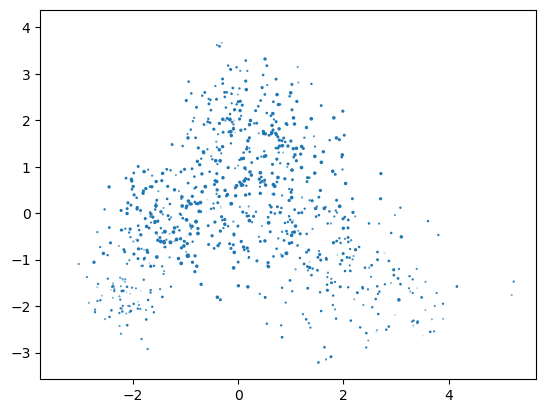

In [120]:
plt.scatter(embeddings_pca[:, 0], embeddings_pca[:, 1], embeddings_pca[:, 2])
plt.show()

In [121]:
embeddings_df = pd.DataFrame(embeddings_pca, columns=['x', 'y', 'z'])

In [122]:
# Create a line plot
scatter_plot = alt.Chart(embeddings_df).mark_point().encode(
    y=alt.Y('y', type="quantitative"),
    x=alt.X('x', type="quantitative"),
).properties(
    title='Scatter plot of entity embeddings - PCA'
)

scatter_plot.properties(width=800, height=600)

alt.Chart(...)

In [37]:
fig = px.scatter_3d(embeddings_df, x='x', y='y', z='z')
fig.update_traces(marker=dict(size=1))
fig.show()

In [ ]:
tsne = TSNE(n_components=3)
embeddings_tsne = tsne.fit_transform(np.array(entities_embeddings))

In [ ]:
tsne_embeddings_df = pd.DataFrame(embeddings_tsne, columns=['x', 'y', 'z'])

In [ ]:
# Create a line plot
scatter_plot = alt.Chart(tsne_embeddings_df).mark_point().encode(
    y=alt.Y('y', type="quantitative"),
    x=alt.X('x', type="quantitative"),
).properties(
    title='Scatter plot of entity embeddings - T-SNE'
)

scatter_plot.properties(width=800, height=600)

alt.Chart(...)

In [ ]:
fig = px.scatter_3d(tsne_embeddings_df, x='x', y='y', z='z')
fig.update_traces(marker=dict(size=2))
fig.show()

# Clustering

In [123]:
all_embeddings = []
all_embedding_counts = []
for entity in embeddings_dict:
    for i in range(entities_freq_filtered2[entity]):
        all_embeddings.append(embeddings_dict[entity])
        all_embedding_counts.append(entities_freq_filtered2[entity])

In [124]:
scaler = Normalizer()
X_minmax = scaler.fit_transform(entities_embeddings)

In [125]:
sse_list = []
silhouette_list = []

for k in range(2, 21):
    kmeans = KMeans(n_clusters=k, n_init=10, max_iter=100, random_state=42)
    kmeans.fit(X_minmax, sample_weight=embedding_counts)
    sse_list.append(kmeans.inertia_)
    silhouette_list.append(silhouette_score(X_minmax, kmeans.labels_))

In [126]:
sse_df = pd.DataFrame([(sse_list[k], k+2) for k in range(0, 19)], columns=['sse', "k"])
silhouette_df = pd.DataFrame([(silhouette_list[k], k+2) for k in range(0, 19)], columns=['silhouette', "k"])

In [127]:
# Create a line plot
sse_plot = alt.Chart(sse_df).mark_line().encode(
    y=alt.Y('sse', type="quantitative", scale=alt.Scale(zero=False)),
    x=alt.X('k', type="quantitative"),
).properties(
    title='SSE'
)

sse_plot.properties(width=800, height=600)

alt.Chart(...)

In [128]:
silhouette_plot = alt.Chart(silhouette_df).mark_line().encode(
    y=alt.Y('silhouette', type="quantitative", scale=alt.Scale(zero=False)),
    x=alt.X('k', type="quantitative"),
).properties(
    title='Silhouette'
)

silhouette_plot.properties(width=800, height=600)

alt.Chart(...)

In [129]:
kmeans = KMeans(n_clusters=8, n_init=10, max_iter=100, random_state=42)
kmeans.fit(X_minmax, sample_weight=embedding_counts)

KMeans(max_iter=100, n_init=10, random_state=42)

In [130]:
centers = kmeans.cluster_centers_

def find_closest_vector(target_vector, vectors):
    # Compute the Euclidean distance from the target vector to all other vectors
    distances = np.linalg.norm(vectors - target_vector, axis=1)
    # Identify the index of the closest vector
    closest_index = np.argmin(distances)
    # Retrieve the closest vector
    closest_vector = vectors[closest_index]
    return closest_vector, closest_index

In [131]:
entity_centers = []
for center in centers:
    #closest_vector, closest_index = find_closest_vector(scaler.inverse_transform(center.reshape(1, -1)), np.array(entities_embeddings))
    closest_vector, closest_index = find_closest_vector(center, X_minmax)
    #closest_entity = embeddings_entities_dict[tuple(closest_vector)]
    closest_entity = embeddings_entities_dict[tuple(entities_embeddings[closest_index])]
    entity_centers.append(closest_entity)

In [132]:
embeddings_df = pd.DataFrame(embeddings_pca, columns=['x', 'y', 'z'])
embeddings_df["color"] = kmeans.labels_

In [133]:
# Create a scatter plot
scatter_plot = alt.Chart(embeddings_df).mark_circle().encode(
    y=alt.Y('y', type="quantitative"),
    x=alt.X('x', type="quantitative"),
    color=alt.Color('color', type="nominal")
).properties(
    title='Scatter plot of entity embeddings with clusters- PCA'
)

scatter_plot.properties(width=800, height=600)

alt.Chart(...)

In [134]:
# Create a selection element for clusters
cluster_selection = alt.selection_single(
    fields=['color'],
    bind=alt.binding_select(options=embeddings_df['color'].unique(), name='Cluster: ')
)

# Create the scatter plot
scatter_plot = alt.Chart(embeddings_df).mark_circle().encode(
    x='x:Q',
    y='y:Q',
    color=alt.condition(
        cluster_selection,
        alt.Color('color:N', legend=None),
        alt.value('lightgrey')
    ),
    tooltip=['x', 'y', 'color']
).add_selection(
    cluster_selection
).properties(
    title='Scatter Plot of Entity Embeddings with Cluster Selection',
    width=800,
    height=600
)

# Display the chart
scatter_plot.display()

c:\Users\giang\anaconda3\envs\env_master\Lib\site-packages\altair\utils\deprecation.py:65: AltairDeprecationWarning:

'selection_single' is deprecated.  Use 'selection_point'

c:\Users\giang\anaconda3\envs\env_master\Lib\site-packages\altair\utils\deprecation.py:65: AltairDeprecationWarning:

'add_selection' is deprecated. Use 'add_params' instead.



alt.Chart(...)

In [135]:
def def_value(): 
    return 0
cluster_dimensions = defaultdict(def_value)
i = 0
for embedding in entities_embeddings:
    entity = embeddings_entities_dict[tuple(embedding)]
    cluster = kmeans.labels_[i]
    cluster_dimensions[cluster] = cluster_dimensions[cluster] + entities_freq_filtered2[entity]
    i = i + 1
    

In [136]:
dict(cluster_dimensions)

{4: 18160, 3: 19779, 0: 16371, 5: 19021, 2: 12181, 7: 8139, 1: 7965, 6: 10023}

In [137]:
Counter(kmeans.labels_)

Counter({0: 517, 3: 502, 4: 392, 5: 195, 2: 132, 7: 61, 1: 9, 6: 2})

In [138]:
entity_centers

['Roma',
 'Agricoltura',
 'Dio',
 'Sindacato',
 'Ortaggio',
 'Società (sociologia)',
 'Italia',
 'Europa']

In [143]:
i = 0
cluster_entities = []
for embedding in entities_embeddings:
    entity = embeddings_entities_dict[tuple(embedding)]
    cluster = kmeans.labels_[i]
    if cluster == 4:
        cluster_entities.append(entity)
    i = i + 1
cluster_entities = sorted(cluster_entities, key=lambda entity: -entities_freq_filtered2[entity])
for entity in cluster_entities:
    print('"' + entity + '"', entities_freq_filtered2[entity], sep=", ")

"Suolo", 1165
"Alimento", 823
"Letame", 756
"Frutta", 696
"Triticum", 692
"Verdura", 685
"Trattore agricolo", 555
"Insecta", 553
"Olio di oliva", 513
"Carne", 366
"Pesticida", 307
"Latte", 291
"Acqua", 282
"Farina", 282
"Parassitismo", 272
"Citrus × sinensis", 261
"Coltura cellulare", 258
"Bos taurus", 228
"Pane", 224
"Solanum tuberosum", 201
"Vicia faba", 184
"Gasolio", 182
"Veleno", 179
"Vaccino", 177
"Caelifera", 175
"Solanum lycopersicum", 172
"Vino", 171
"Olea europaea", 161
"Ettaro", 155
"Pasta", 152
"Chimica", 151
"Ovis aries", 150
"Concime", 145
"Cucumis melo", 129
"Cynara scolymus", 127
"Inquinamento", 126
"Citrus × limon", 125
"Neoplasia", 120
"Formaggio", 118
"Verme", 117
"Temperatura", 116
"Sus scrofa domesticus", 114
"Organismo geneticamente modificato", 110
"Plantae", 108
"Aria", 101
"Cucurbita pepo", 99
"Agrume", 98
"Brassica oleracea", 97
"Carburante", 95
"Pioggia", 92
"Benzina", 91
"Zea mays", 88
"Pesce", 88
"Diserbante", 88
"Ortaggio", 86
"Prodotto fitosanitario", 85


In [140]:
[["Agricoltura", "Agricoltura", 7060], ["Agricoltura", "Allevamento", 435], ["Agricoltura", "Industria", 217], 
 ["Agricoltura", "Pesca (attività)", 160], ["Agricoltura", "Artigianato", 44],
 ["Europa", "Italia", 7971], ["Europa", "Europa", 3111], ["Europa", "Germania", 1290], ["Europa", "Francia", 1142], 
 ["Europa", "Spagna", 242], 
 ["Dio", "Dio", 4166], ["Dio", "Verità", 455], ["Dio", "Libertà", 412],
 ["Dio", "Giustizia", 264], ["Dio", "Coraggio", 212],
 ["Società", "Politica", 1826], ["Società", "Lavoro", 1074], ["Società", "Famiglia", 493], ["Società", "Tradizione", 482], 
 ["Società", "Società", 240],
 ["Suolo", "Suolo", 1165], ["Suolo", "Alimento", 823], ["Suolo", "Letame", 756], ["Suolo", "Grano", 692], 
 ["Suolo", "Trattore agricolo", 555],
 ["Unione europea", "Unione europea", 1719], ["Unione europea", "Sindacato", 1339], ["Unione europea", "Coldiretti", 761],
 ["Unione europea", "Multinazionale", 583], ["Unione europea", "Corruzione", 378],
 ["Roma", "Roma", 2725], ["Roma", "Bruxelles", 1026], ["Roma", "Provincia di Siena", 437], ["Roma", "Sicilia", 391], ["Roma", "Sanremo", 238]
]

[['Agricoltura', 'Agricoltura', 7060],
 ['Agricoltura', 'Allevamento', 435],
 ['Agricoltura', 'Industria', 217],
 ['Agricoltura', 'Pesca (attività)', 160],
 ['Agricoltura', 'Artigianato', 44],
 ['Europa', 'Italia', 7971],
 ['Europa', 'Europa', 3111],
 ['Europa', 'Germania', 1290],
 ['Europa', 'Francia', 1142],
 ['Europa', 'Spagna', 242],
 ['Dio', 'Dio', 4166],
 ['Dio', 'Verità', 455],
 ['Dio', 'Libertà', 412],
 ['Dio', 'Giustizia', 264],
 ['Dio', 'Coraggio', 212],
 ['Società', 'Politica', 1826],
 ['Società', 'Lavoro', 1074],
 ['Società', 'Famiglia', 493],
 ['Società', 'Tradizione', 482],
 ['Società', 'Società', 240],
 ['Suolo', 'Suolo', 1165],
 ['Suolo', 'Alimento', 823],
 ['Suolo', 'Letame', 756],
 ['Suolo', 'Grano', 692],
 ['Suolo', 'Trattore agricolo', 555],
 ['Unione europea', 'Unione europea', 1719],
 ['Unione europea', 'Sindacato', 1339],
 ['Unione europea', 'Coldiretti', 761],
 ['Unione europea', 'Multinazionale', 583],
 ['Unione europea', 'Corruzione', 378],
 ['Roma', 'Roma', 2